# Homework 4 : Observational Studies and Applied ML

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib import gridspec
plt.style.use('fivethirtyeight')
import scipy.stats.mstats as stat

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

import networkx as nx
from networkx.algorithms import bipartite

## Q1. Propensity score matching

We have a dataset (`lalonde`) of an observational study and wish to comment on the effectiveness of a treatment program on the income of a group of people. 

The dataset contains the following information : 
- `id` : anonymised id for the worker
- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

In [2]:
# importing data
data = pd.read_csv('lalonde.csv')

We complete the one-hot encoding of ethnicity by adding another column denoting `white` ethnicity, that will be useful later on for logistic regression. Also, we add a column with the `ethnicity` and `treatment` which will be useful for the pie charts we will show later on.

In [3]:
data['white'] = 1
data['ethnicity'] = 'White'
data['treatment'] = 'Treated'
data.loc[data['black']==1, 'ethnicity'] = 'Black'
data.loc[data['hispan']==1, 'ethnicity'] = 'Hispanic' 
data.loc[data['treat']==0, 'treatment'] = 'Control' 
data.loc[data['black']==1, 'white'] = 0 
data.loc[data['hispan']==1,'white'] = 0
data.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,ethnicity,treatment
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,Black,Treated
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,Hispanic,Treated
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0,Black,Treated
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,Black,Treated
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,Black,Treated
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0,Black,Treated
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0,Black,Treated
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0,Black,Treated
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0,Black,Treated
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,1,White,Treated


Now we divide the dataset into two dataframes based on whether they received the treatment or not.

In [4]:
# Divide the dataset based on group (people who received the treatment vs control)
treated = data[data['treat'] == 1].reset_index()
control = data[data['treat'] == 0]
print('There are {} people in the study, out of which {} were treated and {} were control.'.format(len(data),len(treated), len(control)))

There are 614 people in the study, out of which 185 were treated and 429 were control.


### 1. Naïve analysis 
We will pretend to be naïve and try to show the differences in distributions of the income in 1978 (`re78`) between the two groups, using plots and numbers. 

unobserved covariates ->  Naive model: exclude them because assume “Only observed variables determine treatment assignment”. Bad, naive model is almost never true. -> Use propensity score.
"Adjustments using a model attempt to compare people who are not directly
comparable — people of somewhat different ages or smoking habits — removing
these differences using a mathematical structure that has elements estimated from
the data at hand."


Propensity score -> "if naive model is true, it equals the probability to treat"
e(x) = P(Z=1|x)
Computed by logistic regression. Features x, label Z



In [5]:
# function for plotting
def plot_box_hist(data_to_plot,labels,bins):
    # Boxplot
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
    plt.subplot(gs[0])
    plot = plt.boxplot(data_to_plot, 1, widths=0.5)
    plt.ylabel(labels['plotlabel'])
    plt.xlabel('Group')
    plt.xticks([1, 2], ['Treated', 'Control'])
    plt.title(labels['boxtitle'])
    
    # Distribution (histogram)
    plt.subplot(gs[1])
    plt.hist(data_to_plot[0],alpha=0.6, weights=np.zeros_like(data_to_plot[0]) + 1. / data_to_plot[0].size, bins = bins[0])
    plt.hist(data_to_plot[1],alpha=0.6, weights=np.zeros_like(data_to_plot[1]) + 1. / data_to_plot[1].size, bins = bins[1]) 
    plt.xlabel(labels['plotlabel'])
    plt.ylabel('Proportion of people')
    plt.legend(['Treated','Control'])
    plt.title(labels['histtitle'])

    plt.show()

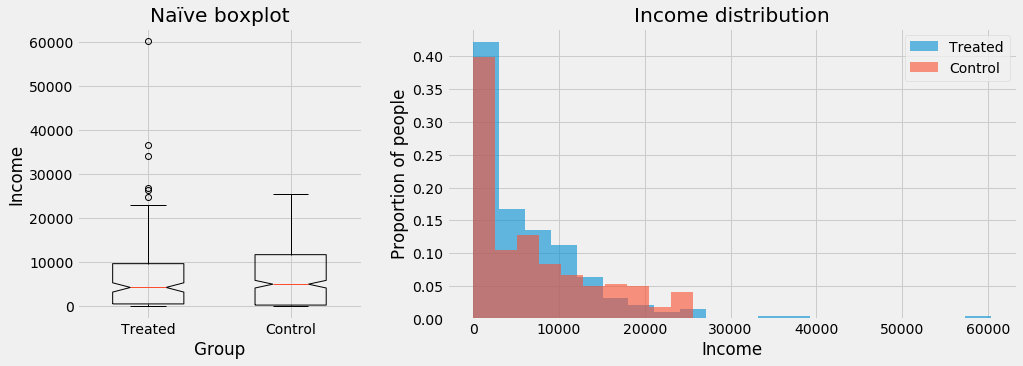

In [6]:
data_to_plot = [treated.loc[:,'re78'], control.loc[:,'re78']]

labels = {'plotlabel': 'Income',\
         'boxtitle': 'Naïve boxplot',\
         'histtitle':'Income distribution'}

plot_box_hist(data_to_plot,labels,[20,10])

The boxplot notch show considerable overlap, we cannot conclude about the difference of medians. The naïve researcher would say this is ineffective or perhaps even harmful. But we should not forget to ask the following questions: 

* Do the two groups come from the same social background?
* Were they having the same income before the treatment?
* Do other features like age, education etc affect the treatment?

Observational studies suffer from this tendency to draw conclusions without looking at the underlying factors properly. We will look at the distributions of the pre-treatment variables (features) to try and address these questions in the following section "_A closer look at the data_"

### 2. A closer look at the data

First, we plot the data of the non-categorical variables and show how the treated and untreated populations differ (or not) in terms of these variables.

We first look at the non-categorical variables, namely Age, Years of Education and pre-treatment incomes (Income in 1974 and Income in 1975)

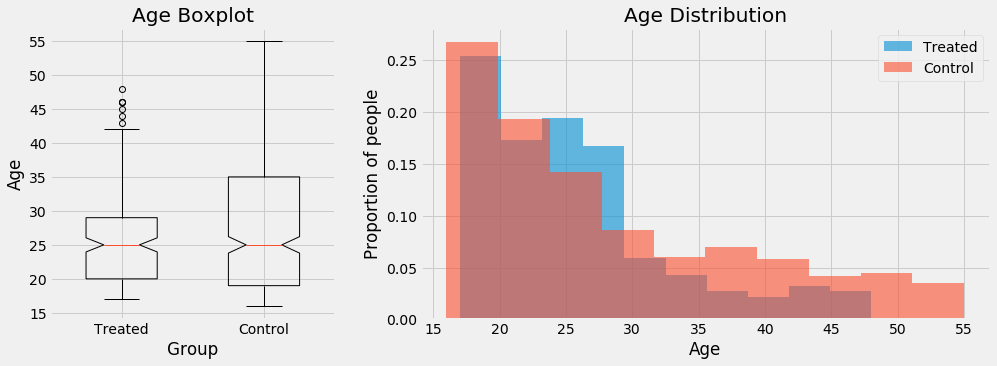

In [7]:
data_to_plot = [treated.loc[:,'age'], control.loc[:,'age']]

labels = {'plotlabel': 'Age',\
         'boxtitle': 'Age Boxplot',\
         'histtitle':'Age Distribution'}

plot_box_hist(data_to_plot,labels, [10,10])

In terms of age, the medians and notches are overlapping, but the control group has a heavy-tailed distribution as seen. The distribution of the control group also has lesser number of outliers.

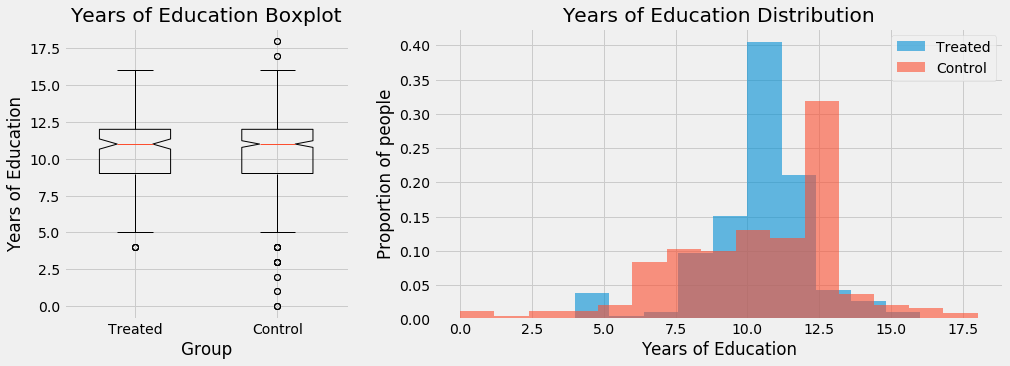

In [8]:
data_to_plot = [treated.loc[:,'educ'], control.loc[:,'educ']]

labels = {'plotlabel': 'Years of Education',\
         'boxtitle': 'Years of Education Boxplot',\
         'histtitle':'Years of Education Distribution'}

plot_box_hist(data_to_plot,labels, [10,15])

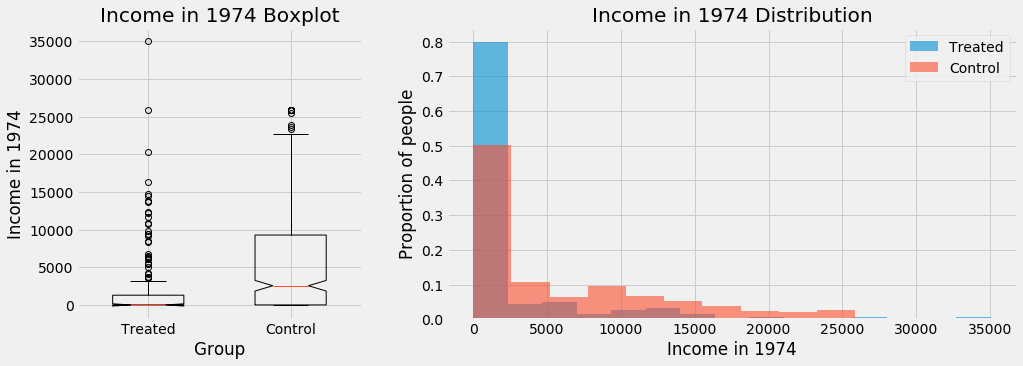

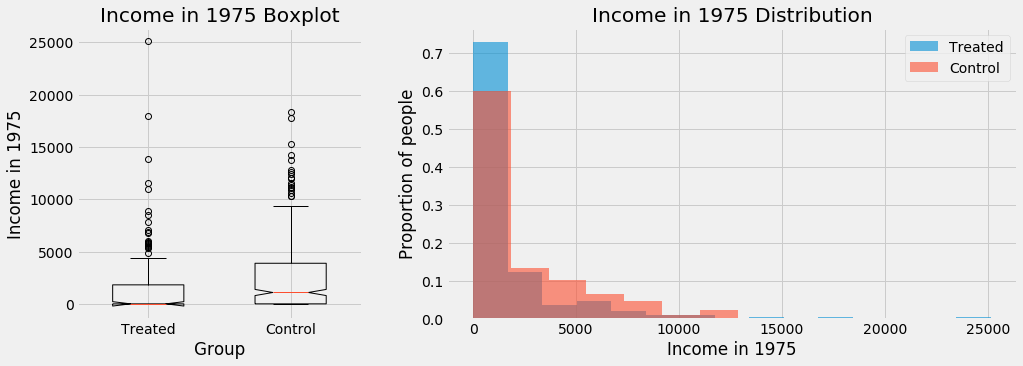

In [9]:
data_to_plot = [treated.loc[:,'re74'], control.loc[:,'re74']]

labels = {'plotlabel': 'Income in 1974',\
         'boxtitle': 'Income in 1974 Boxplot',\
         'histtitle':'Income in 1974 Distribution'}

plot_box_hist(data_to_plot,labels, [15,10])

data_to_plot = [treated.loc[:,'re75'], control.loc[:,'re75']]

labels = {'plotlabel': 'Income in 1975',\
         'boxtitle': 'Income in 1975 Boxplot',\
         'histtitle':'Income in 1975 Distribution'}

plot_box_hist(data_to_plot,labels, [15,10])

We see that there is a significant difference between the Treated and the Control groups in terms of the median notches when it comes to Income in both the years 1974 and 1975. Also, there is a large proportion of people with 0 income in both the groups, especially so in the Treated group. This makes sense as unemployed people _would_ be the ones to take advantage of the treatment program. While this difference exists, it is expected, but the control group should also have had more similar distributions, which is not seen in this case.

The boxplot and distribution show that in terms of years of education also, the data is similarly distributed. Howeverm there are more outliers in the control group here as well.

_**A look at the categorical variables**_

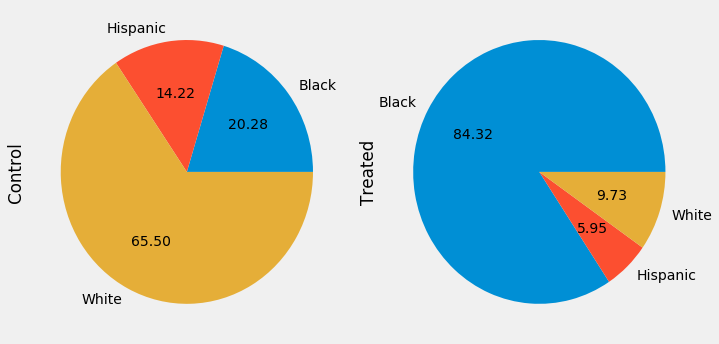

In [10]:
ethnicity = data.groupby(['ethnicity','treatment']).size().unstack(fill_value=0)
ethnicity.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = None,\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

But if we look at the two groups in case of ethnicity, it seem to be _**unbalanced**_. The treated population is overwhelmingly black while the untreated population is mostly white. The other categorical variables are shown below.

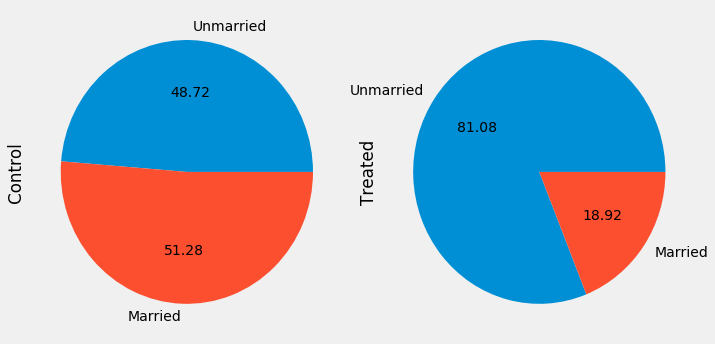

In [11]:
ethnicity = data.groupby(['married','treatment']).size().unstack(fill_value=0)
ethnicity.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = False,\
               labels = ['Unmarried', 'Married'],\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

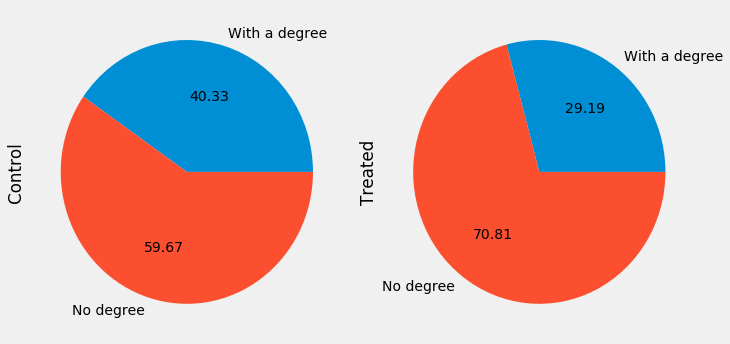

In [12]:
ethnicity = data.groupby(['nodegree','treatment']).size().unstack(fill_value=0)
ethnicity.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = False,\
               labels = ['With a degree','No degree'],\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

We see that there is also a significant difference in the distribution in terms of marital status between the treated and the control group. There is some difference in the case of degrees obtained as well (59.67% versus 70.81% with no degree in the control and treated groups respectively)

_**Observation**_ : The factors of **ethnicity**, **martial status** and to some extent, **degree ownership** as well as **initial income data** are different in terms of distribution between the control and treated groups. So, naïvely concluding that the treatment is not succesful might be wrong, as we would need a better sample in the observational study which gives us a more similarly distributed population between the control and treated groups

### 3. A propensity score model
At this point, we need to interpolate the data in order to obtain two populations of the same characteristic, which do not differ so much in the variable distribution. To do so, we are going to match the data the propensity score. Under the assumption that only observed variables determine treatment assignment, the propensity score represents the probability of receiving the treatment, given the pre-treatement features. Our pre-treatment features include `age`, `educ`, one-hot encoding for the ethnicity (`black`, `hispan`, `white`), `married`, `nodegree` and the two incomes `re74` and `re75`.

First, we choose only the required features from the dataset.

In [13]:
#features and labels
y = np.array(data.treat)
X = data.drop(['id', 'treat','re78','ethnicity','treatment'],axis=1)
X.head(10)

,age,educ,black,hispan,married,nodegree,re74,re75,white
0,37,11,1,0,1,1,0.0,0.0,0
1,22,9,0,1,0,1,0.0,0.0,0
2,30,12,1,0,0,0,0.0,0.0,0
3,27,11,1,0,0,1,0.0,0.0,0
4,33,8,1,0,0,1,0.0,0.0,0
5,22,9,1,0,0,1,0.0,0.0,0
6,23,12,1,0,0,0,0.0,0.0,0
7,32,11,1,0,0,1,0.0,0.0,0
8,22,16,1,0,0,0,0.0,0.0,0
9,33,12,0,0,1,0,0.0,0.0,1


We use logistic regression to estimate the propensity scores

In [14]:
logistic = linear_model.LogisticRegression()  # create the model
logistic.fit(X, y);  # train it

#Predict
yhat = cross_val_predict(logistic, X, y, cv=5)

# Select only the probability to be treated (1)
data['propens'] = logistic.predict_proba(X)[:,1]

Let's see just for its own sake how the model performs. For this we will implement an error function which balances the two classes.

In [15]:
#Check the class error
classes = np.unique(y);
err = np.zeros(len(classes));

for c in range(len(classes)):
    err[c] = sum((y!=yhat) & (y == classes[c]))/sum(y==classes[c]);

err = np.mean(err);
err

0.31496251496251498

In [16]:
data.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,ethnicity,treatment,propens
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,Black,Treated,0.512763
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,Hispanic,Treated,0.293861
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0,Black,Treated,0.648550
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,Black,Treated,0.667477
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,Black,Treated,0.663504
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0,Black,Treated,0.691682
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0,Black,Treated,0.670051
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0,Black,Treated,0.652128
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0,Black,Treated,0.653955
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,1,White,Treated,0.071770


### 4. Balancing the dataset via matching
We now use the `networkx` package to create a bipartite graph from the dataset. 

The vertices of one set in the graph consist of the treated group and the other set are the control group. We add the edges as the negative of the absolute differences between the propensity scores of the vertices. The edges only run from one set to the other (by the definition of a bipartite graph) which we will check later on after the edges are entered. 

We need the negative of the absolute differences because the algorithm we will use to optimise and find a matching would find the maximum weighted full cardinality matching (thus maxing out to correspond to the minimum total value of the absolute difference in propensity scores).

The `id`s would be needed to find in the dataset, later on. 

Before we do the calculation for the whole group, we show a small diagram which illustrates the bipartite graph and shows what we are doing.

In [17]:
B_treated_small = list(treated.id)[:2]
B_control_small = list(control.id)[:4]

# initialise the graph
B_small = nx.Graph()

# add nodes
B_small.add_nodes_from(B_treated_small, bipartite=0)
B_small.add_nodes_from(B_control_small, bipartite=1)

# add edges
for b_treated in B_treated_small:
    for b_control in B_control_small:
        wt =  -np.abs(data[data['id']==str(b_treated)].propens.values - data[data['id']==str(b_control)].propens.values)
        B_small.add_edge(b_treated,b_control,weight = wt)

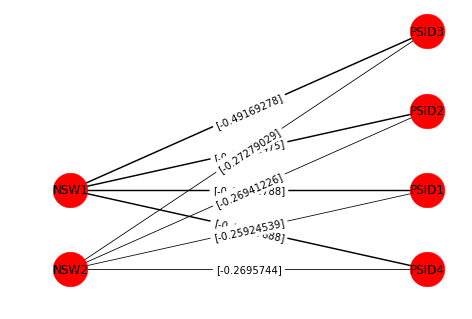

In [18]:
## visualise the small bipartite graph with thickness corresponding to the abs. difference between propensity scores
## scaled up to look prominent

edgewidth = np.abs([d['weight'] for (u,v,d) in B_small.edges(data=True)])[:,0]*3
X, Y = bipartite.sets(B_small)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(B_small, pos=pos, width = edgewidth, with_labels=True,node_size=1200)
labels = nx.get_edge_attributes(B_small,'weight')
nx.draw_networkx_edge_labels(B_small,pos,edge_labels=labels)
plt.show()

In [19]:
# calculate the matching
d = nx.algorithms.max_weight_matching(B_small,maxcardinality=True)

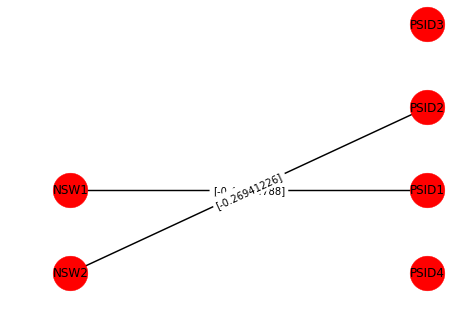

In [20]:
# visualize the newly matched graph
B_new_small = nx.Graph()
B_new_small.add_nodes_from(B_treated_small, bipartite=0)
B_new_small.add_nodes_from(B_control_small, bipartite=1)

# add edges
for key in d.keys():
    if (str(key)[0]=='N'):
        wt =  -np.abs(data[data['id']==str(key)].propens.values - data[data['id']==str(d[key])].propens.values)
        B_new_small.add_edge(key,d[key],weight = wt)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(B_new_small, pos=pos, width = edgewidth, with_labels=True,node_size=1200)
labels = nx.get_edge_attributes(B_new_small,'weight')
nx.draw_networkx_edge_labels(B_new_small,pos,edge_labels=labels)
plt.show()

## Our model fun graph visuals are done, on to the real data!

We will not visualise this as there are too many data points. We follow the exact same procedure as above. 

In [21]:
B_treated = list(treated.id)
B_control = list(control.id)

# let's create a graph... again...
B = nx.Graph()
B.add_nodes_from(B_treated, bipartite=0)
B.add_nodes_from(B_control, bipartite=1)

In [22]:
%%time
# this step is time consuming
for b_treated in B_treated:
    for b_control in B_control:
        wt =  -np.abs(data[data['id']==str(b_treated)].propens.values - data[data['id']==str(b_control)].propens.values)
        B.add_edge(b_treated,b_control,weight = wt)

CPU times: user 2min, sys: 2.62 s, total: 2min 3s
Wall time: 2min 4s


In [23]:
%%time
d = nx.algorithms.max_weight_matching(B,maxcardinality=True)

CPU times: user 4min 55s, sys: 338 ms, total: 4min 56s
Wall time: 4min 56s


In [24]:
df = pd.DataFrame()
for key in d.keys():
    df = pd.concat([df, data[data['id']==key]])

In [25]:
df_t = df[df['treat']==1]
df_c = df[df['treat']==0]

print(len(df_t), len(df_c))

185 185


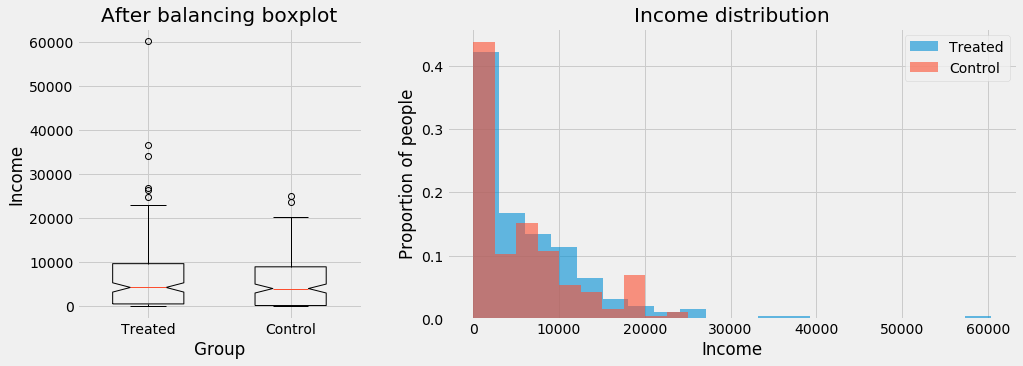

In [26]:
data_to_plot = [df_t.loc[:,'re78'], df_c.loc[:,'re78']]

labels = {'plotlabel': 'Income',\
         'boxtitle': 'After balancing boxplot',\
         'histtitle':'Income distribution'}

plot_box_hist(data_to_plot,labels,[20,10])

We also now compare the distributions of those features which were unbalanced, namely `Income in 1974, 1975`, `married`, `nodegree` and `ethnicity`.

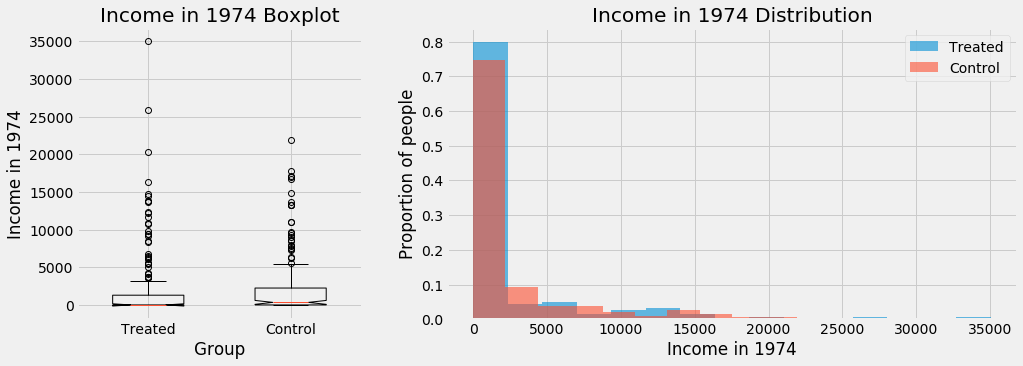

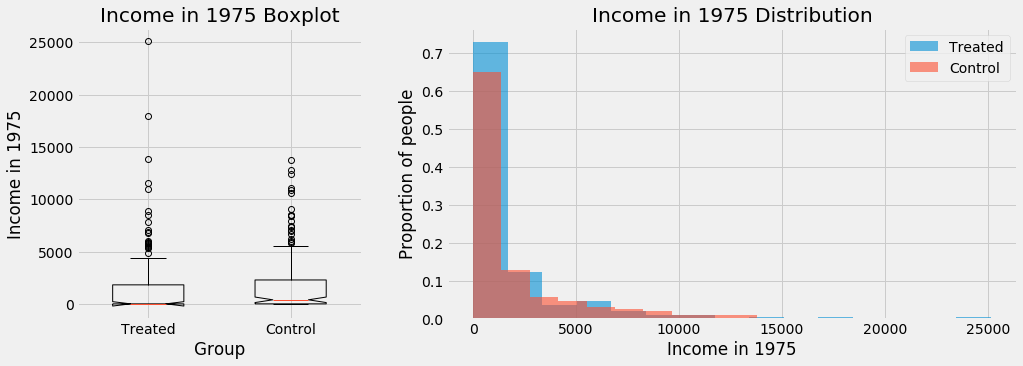

In [27]:
data_to_plot = [df_t.loc[:,'re74'], df_c.loc[:,'re74']]

labels = {'plotlabel': 'Income in 1974',\
         'boxtitle': 'Income in 1974 Boxplot',\
         'histtitle':'Income in 1974 Distribution'}

plot_box_hist(data_to_plot,labels, [15,10])

data_to_plot = [df_t.loc[:,'re75'], df_c.loc[:,'re75']]

labels = {'plotlabel': 'Income in 1975',\
         'boxtitle': 'Income in 1975 Boxplot',\
         'histtitle':'Income in 1975 Distribution'}

plot_box_hist(data_to_plot,labels, [15,10])

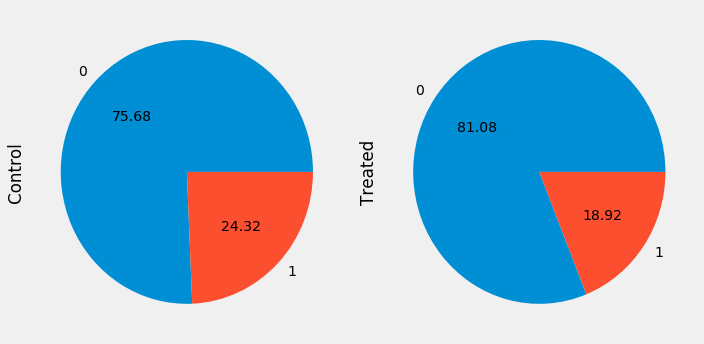

In [28]:
married = df.groupby(['married','treatment']).size().unstack(fill_value=0)
married.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = None,\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

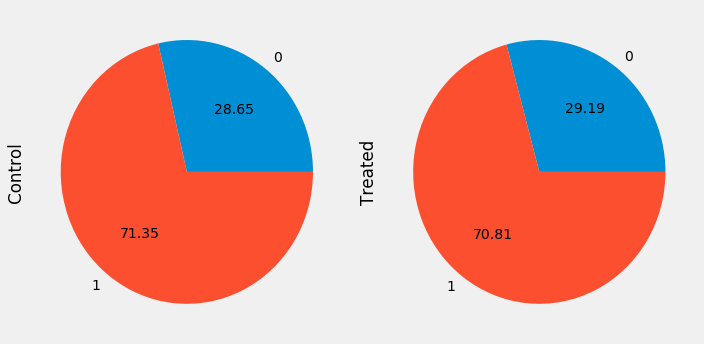

In [29]:
nodegree = df.groupby(['nodegree','treatment']).size().unstack(fill_value=0)
nodegree.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = None,\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

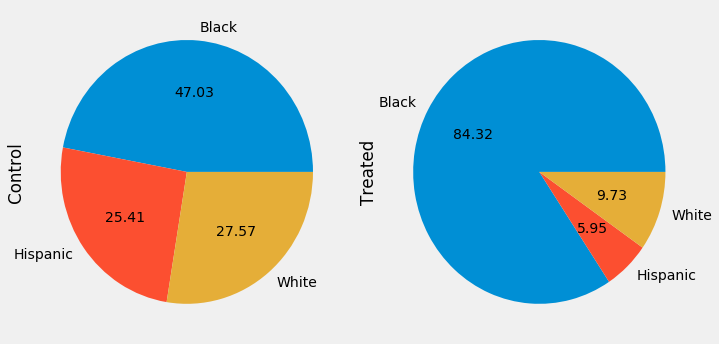

In [30]:
ethnicity = df.groupby(['ethnicity','treatment']).size().unstack(fill_value=0)
ethnicity.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = None,\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

**_OMG_**, we observe all the other features are now balanced, but we are not fully satisfied with our matching in how it handles the case of ethnicity, because there is still an imbalance between the treated and control group on the numbers based on their ethnicity.

We are closer to being able to draw conclusions, but not yet. Martin Luther King Jr.'s dream is yet to be fulfilled, in terms of the ethnicity imbalance...

### 5. Balancing the groups further

The problematic feature, if it may be called so, is the case of ethnicity. The dataset is not definitely balanced in terms of this. So, we decide to make new bipartite graph matchings by explicitly matching the two subjects which have the same value of the ethnicity.

The code below does the exact same thing as the graph based algorithm above, but separately on three graphs which have in them people of the same ethnicity.

In [31]:
treated_b = list(treated[treated.black==1].id)
control_b = list(control[control.black==1].id)

treated_w = list(treated[treated.white==1].id)
control_w = list(control[control.white==1].id)

treated_h = list(treated[treated.hispan==1].id)
control_h = list(control[control.hispan==1].id)

In [32]:
# let's create 3 graphs, one for each ethnicity... again...
B_b = nx.Graph()
B_b.add_nodes_from(treated_b, bipartite=0)
B_b.add_nodes_from(control_b, bipartite=1)

B_w = nx.Graph()
B_w.add_nodes_from(treated_w, bipartite=0)
B_w.add_nodes_from(control_w, bipartite=1)

B_h = nx.Graph()
B_h.add_nodes_from(treated_h, bipartite=0)
B_h.add_nodes_from(control_h, bipartite=1)

In [33]:
%%time
# this step is time consuming
for b_treated in treated_b:
    for b_control in control_b:
        wt =  -np.abs(data[data['id']==str(b_treated)].propens.values - data[data['id']==str(b_control)].propens.values)
        B_b.add_edge(b_treated,b_control,weight = wt)

CPU times: user 19.2 s, sys: 325 ms, total: 19.5 s
Wall time: 19.5 s


In [34]:
%%time
# this step is time consuming
for b_treated in treated_w:
    for b_control in control_w:
        wt =  -np.abs(data[data['id']==str(b_treated)].propens.values - data[data['id']==str(b_control)].propens.values)
        B_w.add_edge(b_treated,b_control,weight = wt)

CPU times: user 7.27 s, sys: 127 ms, total: 7.4 s
Wall time: 7.41 s


In [35]:
%%time
# this step is time consuming
for b_treated in treated_h:
    for b_control in control_h:
        wt =  -np.abs(data[data['id']==str(b_treated)].propens.values - data[data['id']==str(b_control)].propens.values)
        B_h.add_edge(b_treated,b_control,weight = wt)

CPU times: user 987 ms, sys: 21.5 ms, total: 1.01 s
Wall time: 1.01 s


In [36]:
%%time
d_b = nx.algorithms.max_weight_matching(B_b,maxcardinality=True)
d_w = nx.algorithms.max_weight_matching(B_w,maxcardinality=True)
d_h = nx.algorithms.max_weight_matching(B_h,maxcardinality=True)

CPU times: user 21.9 s, sys: 34.5 ms, total: 21.9 s
Wall time: 22 s


In [37]:
df_finally_balanced = pd.DataFrame()
for key in d_b.keys():
    df_finally_balanced = pd.concat([df_finally_balanced, data[data['id']==key]])
for key in d_w.keys():
    df_finally_balanced = pd.concat([df_finally_balanced, data[data['id']==key]])
for key in d_h.keys():
    df_finally_balanced = pd.concat([df_finally_balanced, data[data['id']==key]])

Finally, _finally_, we try to see what changes have been brought to the distribution by this enforced matching on same ethnicity.

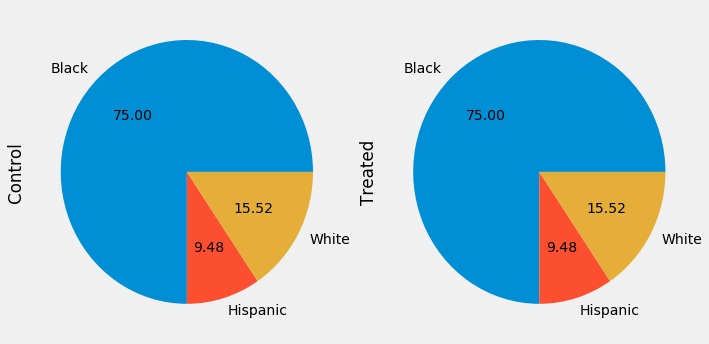

In [38]:
ethnicity = df_finally_balanced.groupby(['ethnicity','treatment']).size().unstack(fill_value=0)
ethnicity.plot(kind = 'pie',\
               subplots = True,\
               use_index = False,\
               legend = None,\
               autopct='%.2f',\
               figsize=(10,5))
plt.tight_layout()

Ok, **whew**, this finally seems to have balanced out the ethnicity imbalance, and now, we can see if really the treatment helped...

In [39]:
df_finally_t = df_finally_balanced[df_finally_balanced['treat']==1]
df_finally_c = df_finally_balanced[df_finally_balanced['treat']==0]

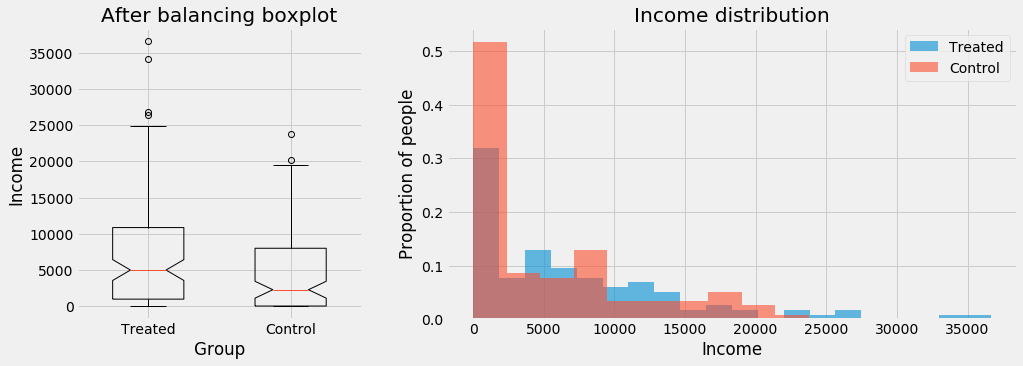

In [40]:
data_to_plot = [df_finally_t.loc[:,'re78'], df_finally_c.loc[:,'re78']]

labels = {'plotlabel': 'Income',\
         'boxtitle': 'After balancing boxplot',\
         'histtitle':'Income distribution'}

plot_box_hist(data_to_plot,labels,[20,10])

We can see a lack of overlap between the notches and a slight increase in the income of the treated group. So, we can conclude that the treatment has some effect!

## Q 2. Applied ML

We are going to featurise the dataset of news articles by using TF-IDF

In [41]:
# fetch the dataset
data = fetch_20newsgroups(subset='all')

In [42]:
# Define a vectorizer to convert the texts into numerical data
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data.data)

In [43]:
# Add the labels to the last column
labeled_vectors = hstack([vectors,data.target[:,None]])

We now split the dataset into training and testing and validation sets. 

In [44]:
# Split into training (80%), validation (10%) and test (10%) sets
train1, test = train_test_split(labeled_vectors,test_size=0.1)
train2, validation = train_test_split(train1,test_size=0.1111)

We train a random forest to the data and fine tune the hyperparameters, the `nEstimators` and the `maxDepth` using a simple grid search. 

In [45]:
%%time
# Do a grid search of the best parameters for number of estimators and max depth of the random forrest classifier
nEstimatorsList = list(range(1,52,10))
maxDepthList = list(range(1,52,10))
scores = np.zeros([len(nEstimatorsList), len(maxDepthList)])
for i, nEstimators in enumerate(nEstimatorsList):
    for j, maxDepth in enumerate(maxDepthList):
        
        clf = RandomForestClassifier(n_estimators=nEstimators, max_depth=maxDepth)
        clf.fit(train2[:,:-1], np.ravel(train2[:,-1].todense()))
        scores[i,j] = clf.score(validation[:,:-1], np.ravel(validation[:,-1].todense()))

CPU times: user 3min 33s, sys: 1.87 s, total: 3min 35s
Wall time: 3min 35s


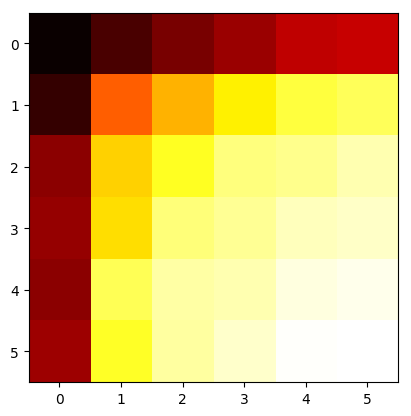

In [46]:
# Shows the validation score, light colors are higher (better) values
with plt.style.context('default'):
    plt.imshow(scores, cmap='hot')
    plt.show()

We can see that the validation score increases with increasing depth and number of estimators. Because this takes a lot of time to run we only go up to 51 for both. Ideally this should be tested for higher values

In [47]:
# Select best classifier from the model selection and fit on the whole training data
clf = RandomForestClassifier(n_estimators=51, max_depth=51)
clf.fit(train1[:,:-1], np.ravel(train1[:,-1].todense()))
ypred = clf.predict(test[:,:-1])

Now we plot the confusion matrix of the classification pipeline

In [48]:
conf_mat = confusion_matrix(np.ravel(test[:,-1].todense()), ypred)

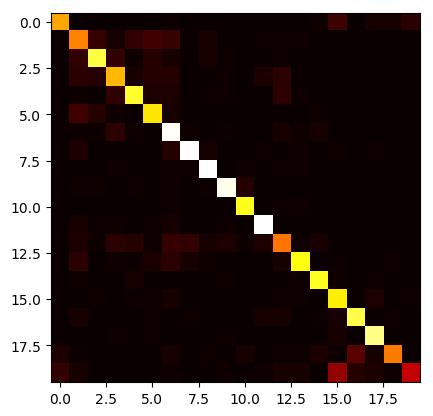

In [49]:
with plt.style.context('default'):
    plt.imshow(conf_mat, cmap='hot')
    plt.show()

Not all groups have the same number of articles, so we normalise the confusion matrix.

In [50]:
conf_mat = normalize(conf_mat, norm='l1', axis=1)

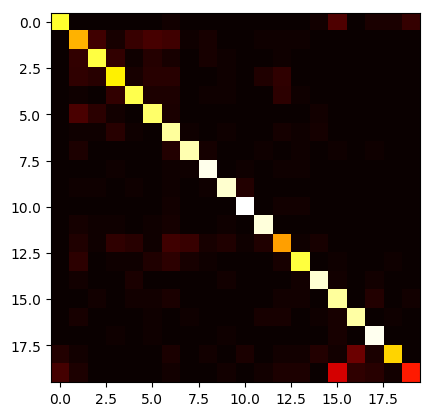

In [51]:
with plt.style.context('default'):
    plt.imshow(conf_mat, cmap='hot')
    plt.show()

con_mat(i,j) is the number of samples in class i that are classified as class j. We see that most values are classified correctly (light values along the diagonal) but some are more difficult to classify than others. For example samples in class 19 (last row) are often classified as class 15. What classes are those?

In [52]:
print(data.target_names[15])
print(data.target_names[19])

soc.religion.christian
talk.religion.misc


Both are on religion and therefore include many of the same words

Let's also look at what are the most important features and words for the classification.

In [53]:
imp = clf.feature_importances_

In [54]:
# Get the indices of the highest ranked features
most_important = imp.argsort()[-10:][::-1]

In [55]:
words = list(vectorizer.vocabulary_.keys())

In [56]:
most_important_words = [words[i] for i in list(most_important.astype(int))]
print(most_important_words)

['cathedra_', 'transaminitis', 'socsec', 'anarchism', 'frizzle', 'defendent', 'zes', 'skyscraper', 'wifdv', 'haywood']


Now, these features are the most important for classifying into the 20 classes mentioned below

In [57]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

If we look at the classes, then keywords like `anarchism`, `transanimists` would help in discriminating into the relgion or politics articles, while others are related to technology like `zumabot` and `wifdv`. These seem to point that some words are typically used in newspapers of that category